# Revisit Logistic Regression from the Neural Network Perspective

## 0 - Preparation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

## 1 - Data Loading

- The data includes a training set of many images labeled as cat (y=1) and non-cat (y=0) and a testing set of similar images.

- Each image has a shape of (number_pixel, number_pixel, 3), which represent picture width, height, RGB channels.

- For the copyright issue, the original dataset is not included in this repo.

In [3]:
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
test_dataset = h5py.File('./datasets/test_catvnoncat.h5', "r")

In [4]:
train_dataset.keys(), test_dataset.keys()

(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [5]:
train_set_x_original = train_dataset['train_set_x']
train_set_y_original = train_dataset['train_set_y']

test_set_x_original = test_dataset['test_set_x']
test_set_y_original = test_dataset['test_set_y']

Visualize an example image

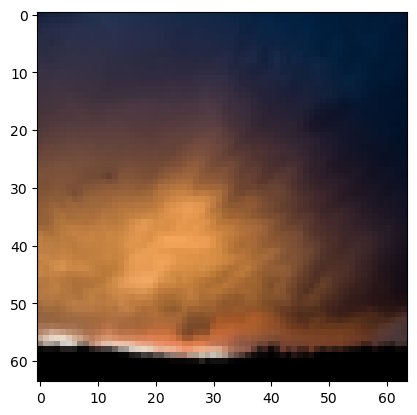

This is a 0


In [6]:
plt.imshow(train_set_x_original[0])
plt.show()
print(f'This is a {train_set_y_original[0]}')

## 2 - Data Examination and Transform

Examine the data

In [7]:
num_train = train_set_x_original.shape[0]
num_test = test_set_x_original.shape[0]
num_width, num_height = train_set_x_original.shape[1], train_set_x_original.shape[2]

In [8]:
num_train, num_test, num_width, num_height

(209, 50, 64, 64)

Each image should be transformed into a vector to be recognized by logistic regression, so I will flatten the dataset.

In [9]:
train_set_x_flat = np.reshape(train_set_x_original, (num_train, num_width * num_height * 3))
test_set_x_flat = np.reshape(test_set_x_original, (num_test, num_width * num_height * 3))

In [10]:
train_set_y = np.reshape(train_set_y_original, (num_train, 1))
test_set_y = np.reshape(test_set_y_original, (num_test, 1))

In [11]:
train_set_x_flat.shape, test_set_x_flat.shape

((209, 12288), (50, 12288))

In [12]:
train_set_y.shape, test_set_y.shape

((209, 1), (50, 1))

Each pixel ranges from 0 to 255, so transform each pixel into 0 to 1

In [13]:
train_set_x = train_set_x_flat / 255.0
test_set_x = test_set_x_flat / 255.0

In [14]:
np.min(train_set_x), np.max(train_set_x)

(0.0, 1.0)

In [15]:
np.min(test_set_x), np.max(test_set_x)

(0.0, 1.0)

## 3 - View Logistic Regression from the Neural Network Perspective

- Each sample (image) $x^{(i)}$ is now a vector with a dimension of `64*64*3 = 12288`
- A logistic regression with `12288` weight parameters and a bias term can be constructed: (superscript refers to the `i-th` sample and subscript denotes the `i-th` feature or weight parameter)

$$
log \frac{p^{(i)}}{1-p^{(i)}} = w_0 + w_1 \cdot x^{(i)}_1 + w_2 \cdot x^{(i)}_2 + ... + w_{12288} * x^{(i)}_{12288}
$$

The formula above is equivalent to:

$$
p^{(i)} = \frac{1}{1 + exp(-z^{(i)})}
$$

where

$$
z = w_0 + w_1 \cdot x^{(i)}_1 + w_2 \cdot x^{(i)}_2 + ... + w_{12288} * x^{(i)}_{12288}
$$

- The logistic regression model above can be viewed as a simple `Neural Network`
- The input layer contains `12288` neurons
- The output layer contains an activation function of `sigmoid`

From the input layer to the ouput layer, the following calculations are performed on each sample $\vec{x}^{(i)}$

$$
z^{(i)} = w_0 + w_1 \cdot x^{(i)}_1 + w_2 \cdot x^{(i)}_2 + ... + w_{12288} * x^{(i)}_{12288} = w_0 + \vec{w}^T \cdot \vec{x}
$$

$$
\hat{y}^{(i)} = sigmoid(z^{(i)}) = \frac{1}{1+exp(-z^{(i)})}
$$

To measure how close our prediction is close to the ground truth, the following loss function is adopted for a `single sample`:

$$
L(\hat{y}^{(i)}, y^{(i)}) =  - y^{(i)}  \log(\hat{y}^{(i)}) - (1-y^{(i)} )  \log(1-\hat{y}^{(i)})
$$

By considering all $n$ samples, the loss function will be:

$$
J = \frac{1}{n} \sum_{i=1}^{n} L(\hat{y}^{(i)}, y^{(i)})
$$

For each weight parameter and bias term, its gradient is calculated as follows:

$$
\frac{\partial{J}}{\partial{\vec{w}}} = \frac{1}{n} X^T (\hat{Y} - Y)
$$


$$
\frac{\partial{J}}{\partial{w_0}} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^{(i)} - y^{(i)})
$$

## 4 - Neural Network Implementation - Functions

`sigmoid` activation function

In [16]:
def sigmoid(z: np.ndarray):
    """
    Compute the sigmoid of z
    """
    return 1.0 / (1.0 + np.exp(-z))

`init_param` function to initialize parameters

In [17]:
def init_param(num_feature):
    """
    Initialize weight vector and bias term
    """
    # always use column vector
    w = np.zeros([num_feature, 1])
    b = 0.0
    return w, b

`forward` function to compute loss and gradient

In [18]:
def forward(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray):
    """
    Arguments
    w: a vector with a dimension of (num_width*num_height*3, 1)
    b: a scalar
    X: a matrix with a shape of (num_samples, num_width*num_height*3)
    Y: a vector with a dimension of (num_samples, 1)

    Return:
    cost: loss function value
    dw: gradient of the loss with respect to w, thus same shape as w
    db: gradient of the loss with respect to b, thus same shape as b
    """
    # calculate the loss
    n = X.shape[0]
    Z = np.dot(X, w) + b  # (num_samples, 1)
    Y_hat = sigmoid(Z)  # (num_samples, 1)
    loss = -1.0 / n * (np.dot(Y.T, np.log(Y_hat)) + np.dot((1 - Y).T, np.log(1 - Y_hat)))
    # calculate the gradient
    dw = 1.0 / n * np.dot(X.T,(Y_hat - Y))
    db = 1.0 / n * np.sum((Y_hat - Y))
    # organize into output format
    loss = np.squeeze(np.array(loss))
    grads = {"dw": dw,
             "db": db}
    
    return grads, loss

`optimize` function relies on gradient descent to update parameters

In [19]:
def optimize(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray, num_iterations: int=100, learning_rate: float=1e-3):
    """
    Arguments:
    w: a vector with a dimension of (num_width*num_height*3, 1)
    b: a scalar
    X: a matrix with a shape of (num_samples, num_width*num_height*3)
    Y: a vector with a dimension of (num_samples, 1)
    
    Returns:
    params: {'w': w value, 'b': b value}
    grads: {'dw': w gradient, 'db': b gradient}
    losses: a list including loss at each step
    """
    losses = []
    # Perform gradient descent
    for i in range(num_iterations):
        # loss
        grads, loss = forward(w, b, X, Y)
        dw, db = grads['dw'], grads['db']
        w = w - learning_rate * grads["dw"]
        b = b - learning_rate * grads["db"]
        
        # Record the costs
        if i % 100 == 0:
            losses.append(loss)
            print ("Loss after iteration %i: %f" %(i, loss))
    # Save results into dict
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    return params, grads, losses

`predict` function to assign labels to new samples

In [20]:
def predict(w, b, X):
    """
    Given X, predict its corresponding Y.

    Arguments:
    w: a vector with a dimension of (num_width*num_height*3, 1)
    b: a scalar
    X: a matrix with a shape of (num_samples, num_width*num_height*3)

    Return:
    Ypred: a vector with a dimension of (num_samples, 1)
    """
    Y_hat = sigmoid(np.dot(X, w) + b)  # (num_samples, 1)
    Y_pred = np.where(Y_hat>0.5, 1, 0)
    return Y_pred

## 5 - Neural Network Implementation - Model

By combining all functions above, we can have a single function to train the model.

In [21]:
def model(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, num_iterations: int=1000, learning_rate: float=1e-3):
    """
    Builds a simple neural network model to simulate logistic regression.

    Arguments:
    X_train: a matrix with a shape of (num_samples, num_width*num_height*3)
    Y_train: a vector with a dimension of (num_samples, 1)
    X_test: a matrix with a shape of (num_samples, num_width*num_height*3)
    Y_test: a vector with a dimension of (num_samples, 1)

    Returns:
    result: {'loss': loss, 'Y_pred_train': Y_pred_train, 'Y_pred_test': Ypred_test, 'w': w, 'b': b}
    """
    num_feature = X_train.shape[1]
    # Step - 1: initialize parameters
    w, b = init_param(num_feature)
    # Step - 2: forward and backward
    params, grads, losses = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    # Step - 3: make predictions
    w, b = params['w'], params['b']
    Y_pred_train = predict(w, b, X_train)
    Y_pred_test = predict(w, b, X_test)
    # Step - 4: save results
    result = {
        'loss': losses,
        'Y_pred_train': Y_pred_train, 
        'Y_pred_test': Y_pred_test, 
        'w': w, 
        'b': b
    }
    return result

In [22]:
nn_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005)

Loss after iteration 0: 0.693147
Loss after iteration 100: 0.584508
Loss after iteration 200: 0.466949
Loss after iteration 300: 0.376007
Loss after iteration 400: 0.331463
Loss after iteration 500: 0.303273
Loss after iteration 600: 0.279880
Loss after iteration 700: 0.260042
Loss after iteration 800: 0.242941
Loss after iteration 900: 0.228004
Loss after iteration 1000: 0.214820
Loss after iteration 1100: 0.203078
Loss after iteration 1200: 0.192544
Loss after iteration 1300: 0.183033
Loss after iteration 1400: 0.174399
Loss after iteration 1500: 0.166521
Loss after iteration 1600: 0.159305
Loss after iteration 1700: 0.152667
Loss after iteration 1800: 0.146542
Loss after iteration 1900: 0.140872


## 6 Post-Model Analysis

Visualize the loss variation

In [23]:
losses = np.squeeze(nn_model['loss'])

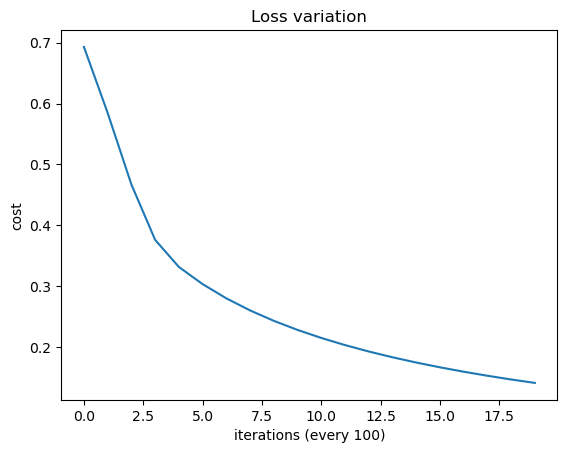

In [24]:
fig = plt.figure()
plt.plot(losses)
plt.ylabel('cost')
plt.xlabel('iterations (every 100)')
plt.title("Loss variation")
plt.show()

Visualize accuracy

In [25]:
acc_train = np.squeeze(nn_model['Y_pred_train'] == train_set_y).mean()
acc_test = np.squeeze(nn_model['Y_pred_test'] == test_set_y).mean()

In [26]:
acc_train, acc_test

(0.9904306220095693, 0.7)

Use my own cat

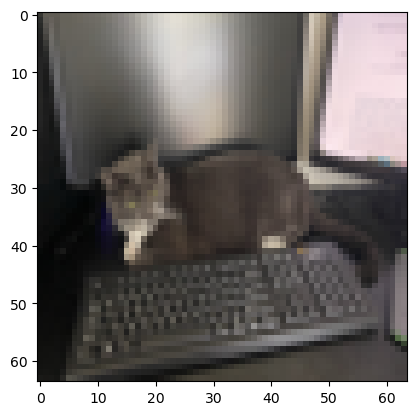

In [27]:
image = np.array(Image.open('images/my_image.jpeg').resize((num_width, num_height)))
plt.imshow(image)
plt.show()

In [28]:
image = image / 255.
image = image.reshape((1, num_width * num_height * 3))

In [29]:
my_cat_pred = predict(nn_model["w"], nn_model["b"], image)

print(my_cat_pred)

[[1]]
